#Gold Future Prices

____________________
By Ahmed Ali

##Environment set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

##Prepare Data

In [2]:
df= pd.read_csv('/content/future-gc00-daily-prices.csv',index_col='Date')
df.head()


,Open,High,Low,Close
Date,,,,
01/02/2013,"1,676.40","1,695.40","1,670.90","1,688.80"
01/02/2014,"1,204.50","1,230.80","1,202.50","1,225.20"
01/02/2015,"1,184.00","1,194.90","1,167.30","1,186.20"
01/02/2018,"1,305.30","1,320.40","1,304.60","1,316.10"
01/02/2019,"1,285.00","1,291.00","1,280.60","1,284.10"


In [3]:
df.drop(columns=['Open','High','Low'],inplace=True)
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df.head()


,Price
Date,
01/02/2013,1688.8
01/02/2014,1225.2
01/02/2015,1186.2
01/02/2018,1316.1
01/02/2019,1284.1


In [4]:
df.shape

(3703, 1)

##Check for stationarity
the Augmented Dickey-Fuller test

In [5]:
result = adfuller(df["Price"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -11.710736957008969
p-value: 1.4911408533201081e-21


In [6]:
if result[1] > 0.05:
  df["Price"] = df["Price"].diff().dropna()
  result = adfuller(df["Price"])
stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -11.710736957008969
p-value after differencing: 1.4911408533201081e-21
Interpretation: The series is Stationary.


The ADF statistic is highly negative.

The p-value is extremely small (essentially 0).

You can confidently reject the null hypothesis and conclude that the time series is stationary.

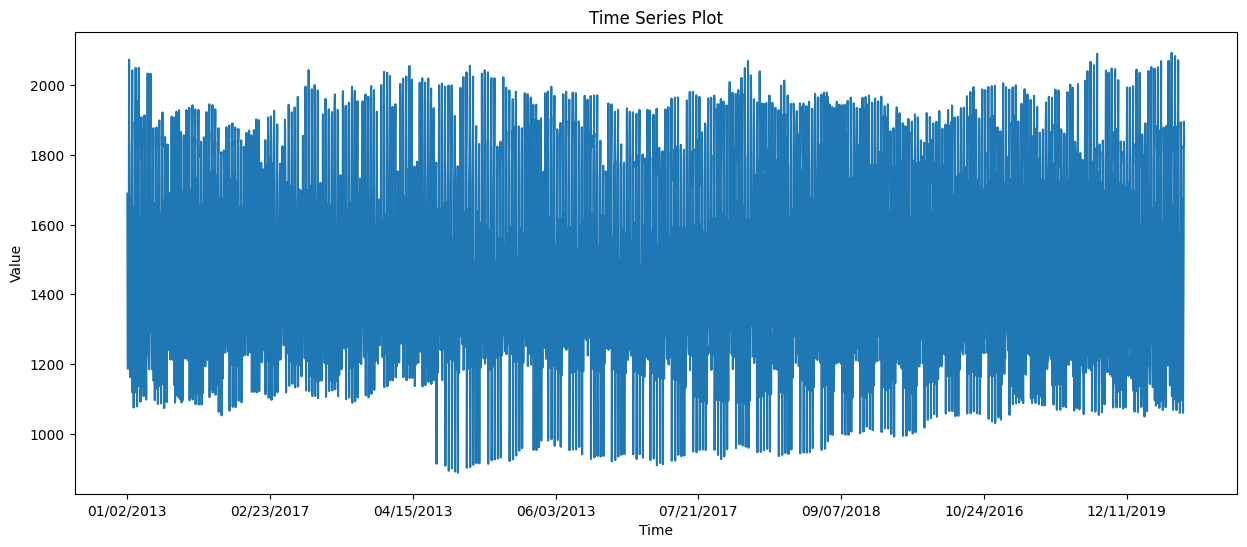

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
df['Price'].plot(ax=ax);
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##Handle missing values

In [8]:
df.fillna(method='ffill', inplace=True)  # fill missing values

## Parameter estimation



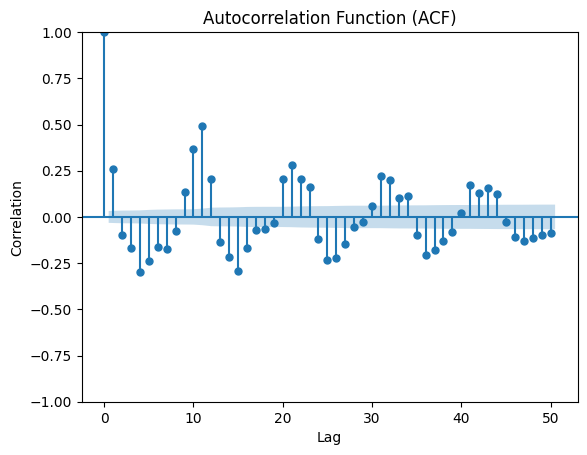

In [9]:
plot_acf(df["Price"], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

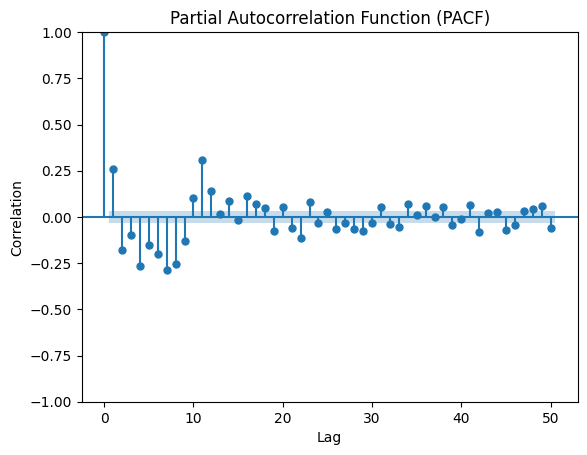

In [10]:
plot_pacf(df["Price"], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

#Build Model

##Baseline

In [11]:
y=df['Price']
cutoff_test = int(len(y)*0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3332,)
y_test shape: (371,)


In [12]:
y_train_mean = y_train.mean()
y_pred = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 1464.95
Baseline MAE: 253.29


##Iterate

In [13]:
p_params = range(0,25,8)
q_params = range(0,3,1)
mae_grid = {}
for p in p_params:
  mae_grid[p] = []
  for q in q_params:
    order = (p,0,q)
    start_time = time.time()
    model = ARIMA(y_train, order=(p, 0, q)).fit()
    elapsed_time=round(time.time()- start_time,2)
    print(f'Trained ARIMA model {order} in {elapsed_time} seconds"')
    y_pred = model.predict()
    mae = mean_absolute_error(y_train,y_pred)
    mae_grid[p].append(mae)
    print(f'MAE for order {order}: {mae}')

print(mae_grid)



Trained ARIMA model (0, 0, 0) in 1.55 seconds"
MAE for order (0, 0, 0): 253.2910839912609
Trained ARIMA model (0, 0, 1) in 2.8 seconds"
MAE for order (0, 0, 1): 229.6928996929083
Trained ARIMA model (0, 0, 2) in 1.95 seconds"
MAE for order (0, 0, 2): 230.91230276090778
Trained ARIMA model (8, 0, 0) in 7.28 seconds"
MAE for order (8, 0, 0): 187.17570773606172
Trained ARIMA model (8, 0, 1) in 13.1 seconds"
MAE for order (8, 0, 1): 186.17291435354002
Trained ARIMA model (8, 0, 2) in 21.45 seconds"
MAE for order (8, 0, 2): 173.06137500187216
Trained ARIMA model (16, 0, 0) in 12.84 seconds"
MAE for order (16, 0, 0): 166.11012113172944
Trained ARIMA model (16, 0, 1) in 29.19 seconds"
MAE for order (16, 0, 1): 166.0248597352328
Trained ARIMA model (16, 0, 2) in 54.89 seconds"
MAE for order (16, 0, 2): 165.81087813969307
Trained ARIMA model (24, 0, 0) in 23.75 seconds"
MAE for order (24, 0, 0): 163.24122346537348
Trained ARIMA model (24, 0, 1) in 130.02 seconds"
MAE for order (24, 0, 1): 163.1

<Axes: >

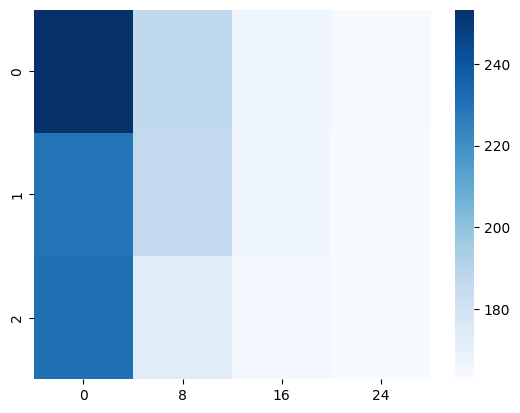

In [14]:
mae_df = pd.DataFrame(mae_grid)
sns.heatmap(mae_df,cmap ='Blues')

##Evaluate

In [29]:
y_pred_wfv = []
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history,order=(16,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

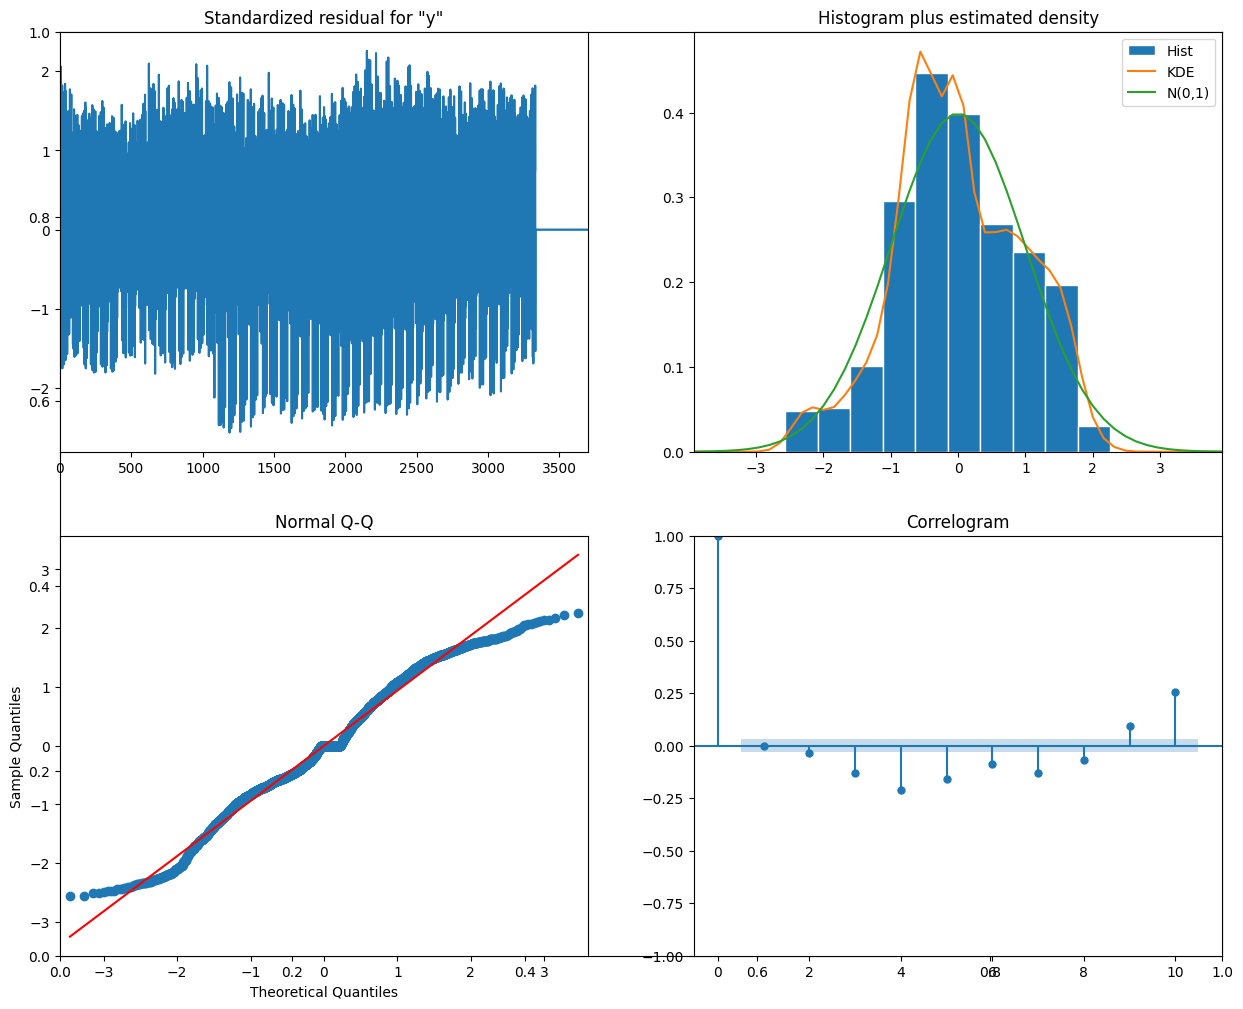

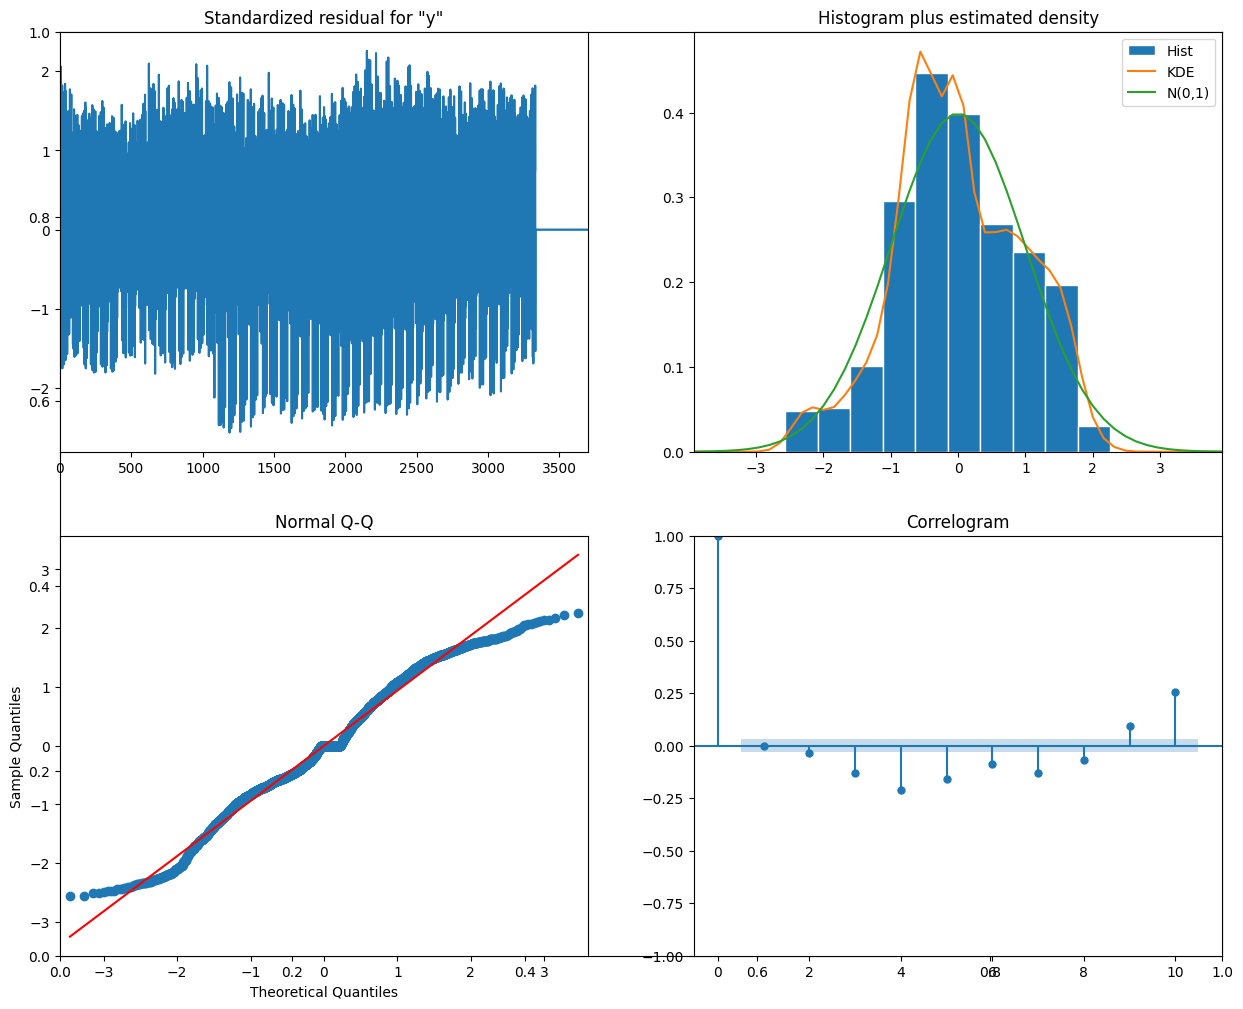

In [30]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)

In [ ]:
df_predictions = pd.DataFrame({'y_test':y_test,'y_pred_wfv':y_pred_wfv})
fig = px.line(df_predictions)
fig.show()